In [211]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [212]:
df = pd.read_csv("cleaned_data/02-cleaned.csv")

In [213]:
df

,datetime,temp,dew,humidity,windspeed,winddir,sealevelpressure,precipitation
0,2016-07-01,21.1,68.9,96.8,9.2,78.4,1009.1,53.1000
1,2016-07-02,21.7,69.0,93.9,9.2,172.1,1009.8,13.7000
2,2016-07-03,23.2,69.8,88.4,12.8,216.1,1007.7,2.0000
3,2016-07-04,23.7,69.4,84.5,5.8,177.7,1006.3,16.8000
4,2016-07-05,24.3,69.9,82.7,11.4,110.0,1005.7,3.8000
...,...,...,...,...,...,...,...,...
3282,2025-06-26,24.8,71.6,85.9,11.4,220.1,1011.7,9.9000
3283,2025-06-27,24.8,71.1,84.0,12.8,237.0,1010.3,18.8000
3284,2025-06-28,24.5,70.5,84.3,11.4,278.3,1009.3,3.8000
3285,2025-06-29,23.1,71.4,94.2,16.1,223.2,1006.8,16.9672


In [214]:
df["datetime"] = pd.to_datetime(df["datetime"])


In [215]:
df.dtypes

datetime            datetime64[ns]
temp                       float64
dew                        float64
humidity                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
precipitation              float64
dtype: object

In [216]:
def get_season(date):
    """
    Function to determine the season in Nepal based on the given date.
    Args:
        date (pd.Timestamp): A datetime object.
    Returns:
        str: The season corresponding to the date.
    """
    month = date.month
    day = date.day

    # Spring: Mid-March to Mid-May (blooming season, pre-monsoon)
    if (month == 3 and day >= 15) or (month == 4) or (month == 5 and day <= 15):
        return "Spring"
    
    # Summer/Monsoon: 
    # - Early Summer (pre-monsoon heat): Mid-May to Mid-June
    # - Peak Monsoon: Mid-June to Mid-September
    elif (month == 5 and day > 15) or (month == 6 and day <= 15):
        return "Summer(Pre-Monsoon)"
    elif (month == 6 and day > 15) or (month == 7) or (month == 8) or (month == 9 and day <= 15):
        return "Monsoon"
    
    # Autumn: Mid-September to Mid-November (post-monsoon, harvest season)
    elif (month == 9 and day > 15) or (month == 10) or (month == 11 and day <= 15):
        return "Autumn"
    
    # Winter: Mid-November to Mid-March (cold, dry season)
    else:
        return "Winter"

In [217]:
df["month"] = df["datetime"].dt.month
df['season'] = df['datetime'].apply(get_season)


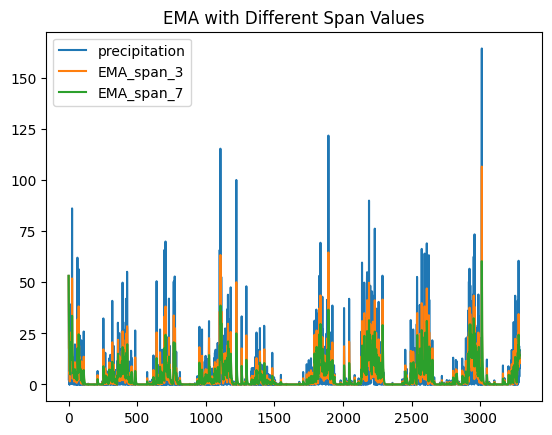

<Figure size 5000x2500 with 0 Axes>

In [218]:
spans = [3,7]
for span in spans:
    df[f'EMA_span_{span}'] = df['precipitation'].ewm(span=span, adjust=False).mean()

df[['precipitation'] + [f'EMA_span_{span}' for span in spans]].plot()

plt.title('EMA with Different Span Values')
plt.figure(figsize=(50,25))

plt.show()

In [219]:
#rolling averages introduce lag, particularly when using simple movingaverages (SMA) with fixed window sizes
# so we use  exponential moving averages (EMA), which assign higher weights to more recent observations

#A smaller span gives more weight to recent observations, making the EMA more responsive to changes but also more volatile.
#A larger span smooths out fluctuations, giving equal importance to a broader range of past observations.

span = 3
df["temp_EMA_7_days"] = df['temp'].ewm(span=span, adjust=False).mean()


### Constructing Lagged Variables for Temperature and Humidity

In [220]:

df['humidity_lag_3_days'] = df['humidity'].shift(3)
df['precipitation_lag_2_days']=df['precipitation'].shift(2)

In [221]:
df.dtypes

datetime                    datetime64[ns]
temp                               float64
dew                                float64
humidity                           float64
windspeed                          float64
winddir                            float64
sealevelpressure                   float64
precipitation                      float64
month                                int32
season                              object
EMA_span_3                         float64
EMA_span_7                         float64
temp_EMA_7_days                    float64
humidity_lag_3_days                float64
precipitation_lag_2_days           float64
dtype: object

In [222]:
df.isna().sum()

datetime                    0
temp                        0
dew                         0
humidity                    0
windspeed                   0
winddir                     0
sealevelpressure            0
precipitation               0
month                       0
season                      0
EMA_span_3                  0
EMA_span_7                  0
temp_EMA_7_days             0
humidity_lag_3_days         3
precipitation_lag_2_days    2
dtype: int64

In [223]:
# adjusting the null values in the newly created features

df.humidity_lag_3_days = df.humidity_lag_3_days.fillna(df.humidity_lag_3_days.iloc[3:11].mean()) #applying 1 week avg
df.precipitation_lag_2_days = df.precipitation_lag_2_days.fillna(df.precipitation_lag_2_days.iloc[2:10].mean()) # applying 1 week avg


In [224]:
#  approach captures the cyclical nature of months while reducing dimensionality compared to one-hot encoding 
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [225]:
df.head()

,datetime,temp,dew,humidity,windspeed,winddir,sealevelpressure,precipitation,month,season,EMA_span_3,EMA_span_7,temp_EMA_7_days,humidity_lag_3_days,precipitation_lag_2_days,month_sin,month_cos
0,2016-07-01,21.1,68.9,96.8,9.2,78.4,1009.1,53.1,7,Monsoon,53.100,53.100000,21.10,87.425,11.975,-0.5,-0.866025
1,2016-07-02,21.7,69.0,93.9,9.2,172.1,1009.8,13.7,7,Monsoon,33.400,43.250000,21.40,87.425,11.975,-0.5,-0.866025
2,2016-07-03,23.2,69.8,88.4,12.8,216.1,1007.7,2.0,7,Monsoon,17.700,32.937500,22.30,87.425,53.100,-0.5,-0.866025
3,2016-07-04,23.7,69.4,84.5,5.8,177.7,1006.3,16.8,7,Monsoon,17.250,28.903125,23.00,96.800,13.700,-0.5,-0.866025
4,2016-07-05,24.3,69.9,82.7,11.4,110.0,1005.7,3.8,7,Monsoon,10.525,22.627344,23.65,93.900,2.000,-0.5,-0.866025


In [226]:
seasons_dict = {'Spring': 1, 
                'Summer(Pre-Monsoon)': 2, 
                'Monsoon': 3, 
                'Autumn': 4, 
                'Winter': 5
                }

In [227]:
# mapping seasons to it's numbers by creating a new column
df["season_number"] = df["season"].map(seasons_dict)

In [228]:
total_seasons = len(seasons_dict.items())
total_seasons

5

In [229]:
# implementing cyclic encoding on the season

df["season_sin"] = np.sin(2 * np.pi * df['season_number'] / total_seasons)
df["season_cos"] = np.cos(2 * np.pi * df['season_number'] / total_seasons)

In [230]:
# df.to_csv("test.csv",index=False)

In [231]:
# Integrates temperature and humidity to measure perceived heat.
# Provides actionable insights for extreme weather conditions.
df["heat index"] = df.temp - ((100 - df.humidity)/5)

# df["wind chill"] = df.temp * df.windspeed


In [232]:
# Vapor Pressure Deficit (VPD)
# Derived from temperature and humidity, crucial for predicting drought stress and fire risks.
# VPD significantly influences vegetation productivity and wildfire risks.

def VPD(row):
    # Calculate saturation vapor pressure (e_s)
    e_s = 6.1708 * np.exp((17.2 * row["temp"]) / (row["temp"] + 237.3))
    
    # Calculate actual vapor pressure (e_a)
    e_a = round(row["temp"] * row["humidity"] / 100, 1)
    
    # Return the vapor pressure deficit (VPD)
    return e_s - e_a

df["Vapor Pressure Deficit"] = df.apply(VPD, axis=1)


In [233]:
# Helps understand atmospheric aridity and its impact on precipitation.
df["dew_point_depression"]=df.temp - df.dew 

In [234]:
# Seasonal Wind Direction Patterns

# Encodes wind direction with sine/cosine transformations to capture seasonal variations.
# Enhances the ability to model cyclical trends in precipitation data.

df['winddir_sin'] = np.sin(np.radians(df['winddir']))
df['winddir_cos'] = np.cos(np.radians(df['winddir']))

# Combining these with seasonal encodings (season_sin, season_cos)
df['combined_seasonal_wind_pattern'] = np.sqrt(
    df['winddir_sin']**2 + df['winddir_cos']**2 + df['season_sin']**2 + df['season_cos']**2
)

In [235]:
# Temperature-Humidity Interaction (Cross-Lagged)
# Cross-lagged interactions between temperature and humidity changes over time.
#  Capturing lagged effects improves understanding of complex environmental interactions.
df['temp_humidity_interaction'] = (
    (df['temp'] - df['temp_EMA_7_days']) *
    (df['humidity'] - df['humidity_lag_3_days'])
)

In [48]:
# Wind-driven moisture flux:
df['moisture_flux'] = df['windspeed'] * np.sin(np.radians(df['winddir'])) * df['humidity']


#### Rainfall-related features tailored to Kathmandu's geography

In [237]:
""" Orographic Precipitation Potential
#Estimates the likelihood of orographic rainfall caused by moist air rising over hills.
#Hills surrounding Kathmandu force moist air to rise, cool, and condense, leading to enhanced rainfall on windward slopes and rain shadows on leeward slopes.
"""
df['orographic_precipitation_potential'] = df['windspeed'] * np.sin(np.radians(df['winddir'])) * df['humidity']

#Positive values indicate windward slopes (enhanced rainfall).
#Negative values indicate leeward slopes (rain shadow).

In [238]:
"""
Valley Temperature Inversion Index
#Captures temperature inversion events where cooler air gets trapped in the valley.
# Temperature inversions are common in valleys like Kathmandu, especially during winter nights, and can suppress rainfall.
"""
# Placeholder for elevation difference (e.g., 500 meters)
delta_z = 500
df['temperature_inversion_index'] = (df['temp'] - df['dew']) / delta_z

In [239]:
"""
Wind Channeling Effect
#  Measures how wind speed and direction interact with the valley's topography.
#  Winds are often channeled through valleys, affecting local precipitation patterns.
"""
df['wind_channeling_effect'] = df['windspeed'] * np.cos(np.radians(df['winddir']))

In [49]:
"""
Rain Shadow Effect
# Quantifies the reduction in precipitation due to rain shadowing on the leeward side of hills.
# Kathmandu lies in a rain shadow during certain wind directions, reducing rainfall.
"""
#Negative sine values indicate leeward slopes.
df['wind_shadow_effect'] = np.maximum(0, -np.sin(np.radians(df['winddir']))) * df['windspeed']

In [241]:
"""
 Urban Heat Island Effect on Rainfall
Description : Captures how urbanization in Kathmandu modifies local rainfall patterns.
Justification : Urban heat islands can enhance convection and localized rainfall.
"""
df['urban_heat_island_effect'] = df['temp'] - df['dew'] + (df['sealevelpressure'] / 1000)

In [242]:
""" 
Convective Rainfall Potential
Description : Estimates the potential for convective rainfall driven by localized heating in the valley.
Justification : Convective storms are common in Kathmandu during pre-monsoon and monsoon seasons.
"""
df['convective_rainfall_potential'] = ((df['temp'] - df['dew']) * df['windspeed']) / df['humidity']

In [243]:
# df.to_csv("test.csv",index=False)

In [244]:
"""  
Valley-Wind Interaction
Description : Captures how valley winds interact with precipitation.
Justification : Wind patterns in Kathmandu are influenced by the surrounding hills, affecting rainfall distribution.
 """
df['valley_wind_interaction'] = df['precipitation'] * np.cos(np.radians(df['winddir'])) * df['windspeed']

In [245]:
"""  
Rainfall-Wind Interaction
Description : Captures the combined effect of rainfall and wind on surface conditions.
Justification : Wind-driven rain can exacerbate flooding or erosion.
"""
df['rainfall_wind_interaction'] = df['precipitation'] * df['windspeed']

In [246]:
"""  
Precipitation Efficiency
Description : Measures how effectively atmospheric moisture is converted into rainfall.
Justification : Indicates the efficiency of the hydrological cycle.
"""
df['precipitation_efficiency'] = df['precipitation'] / df['humidity']

In [247]:
"""   
Convective Precipitation Potential
Description : Estimates the likelihood of convective rainfall based on temperature and humidity gradients.
Justification : Convection-driven rainfall is common in thunderstorms.
"""
df['convective_precipitation_potential'] = ((df['temp'] - df['dew']) * df['windspeed']) / df['sealevelpressure']

In [248]:

len(df.dtypes)

38

In [249]:
df.isna().sum()

datetime                              0
temp                                  0
dew                                   0
humidity                              0
windspeed                             0
winddir                               0
sealevelpressure                      0
precipitation                         0
month                                 0
season                                0
EMA_span_3                            0
EMA_span_7                            0
temp_EMA_7_days                       0
humidity_lag_3_days                   0
precipitation_lag_2_days              0
month_sin                             0
month_cos                             0
season_number                         0
season_sin                            0
season_cos                            0
heat index                            0
Vapor Pressure Deficit                0
dew_point_depression                  0
winddir_sin                           0
winddir_cos                           0


In [250]:
df.duplicated().sum()

0

In [251]:
df.to_csv("cleaned_data/03-interaction_features.csv",index=False)

# now visualizing and interpreting the relations between target and other features

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df  = pd.read_csv("cleaned_data/03-interaction_features.csv")

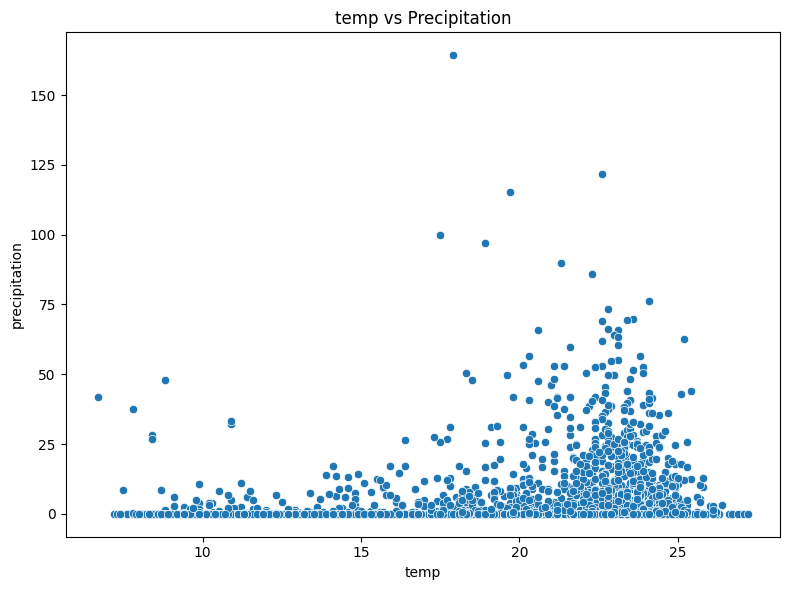

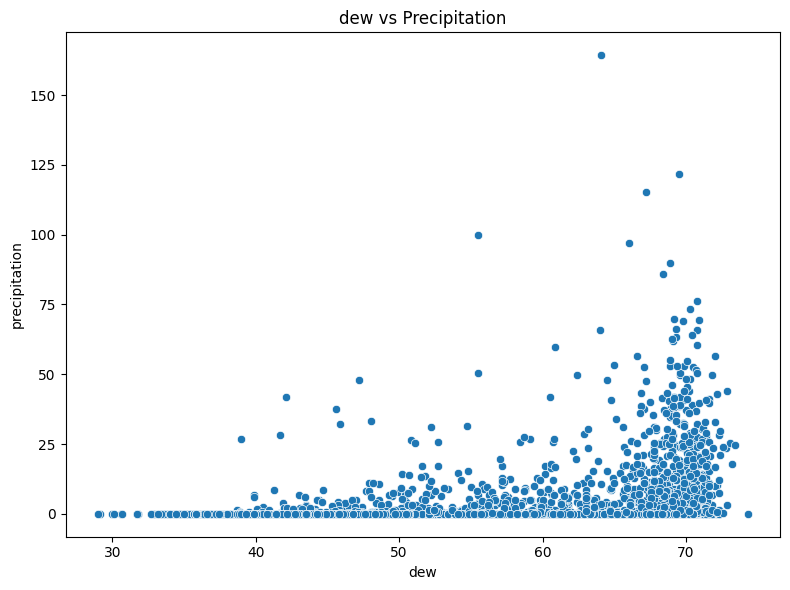

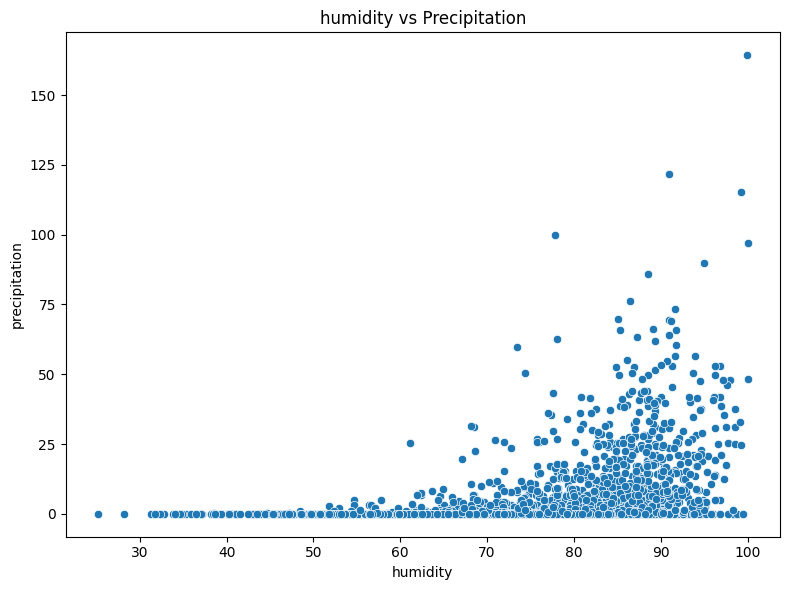

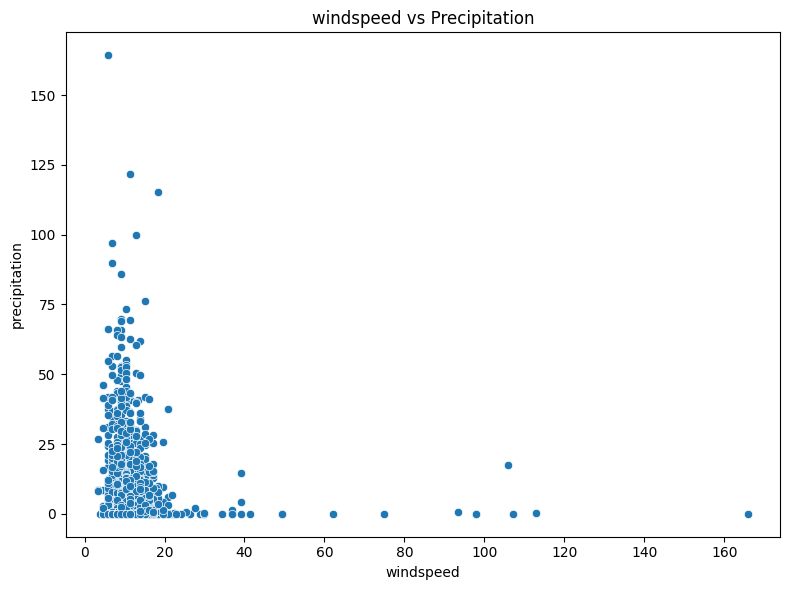

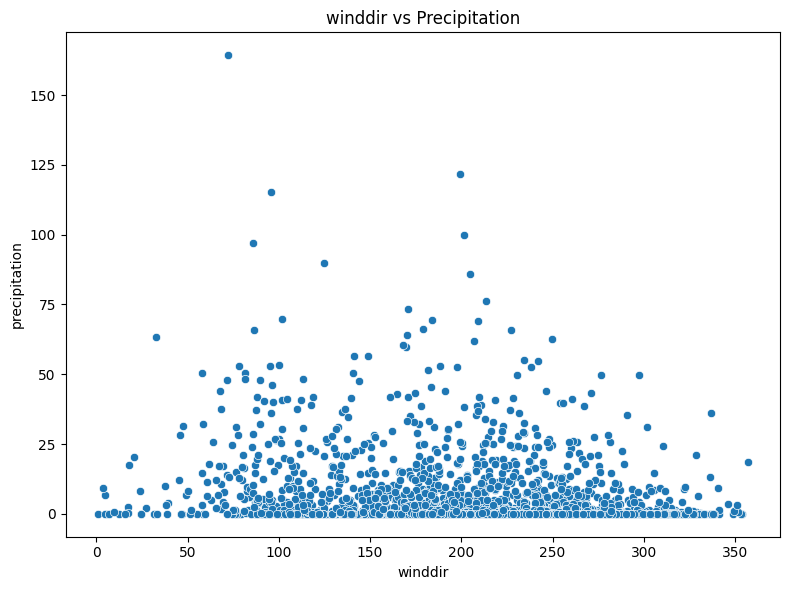

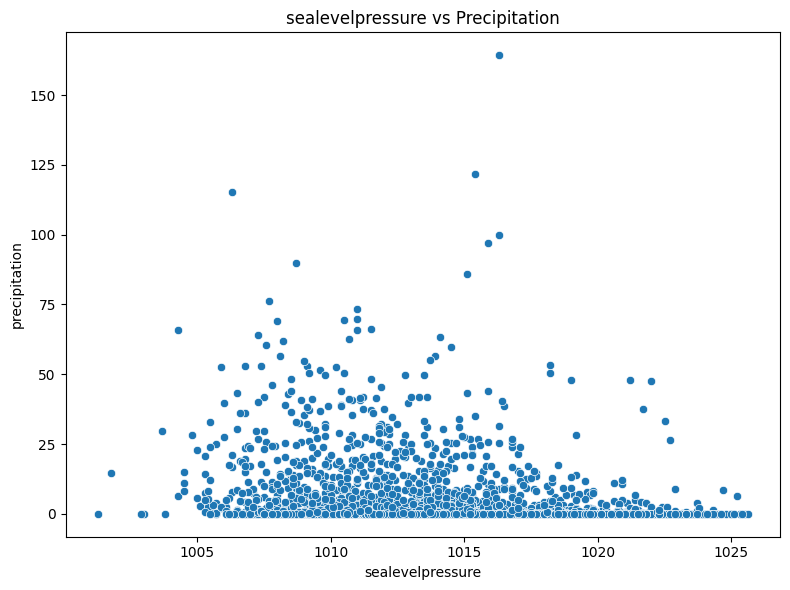

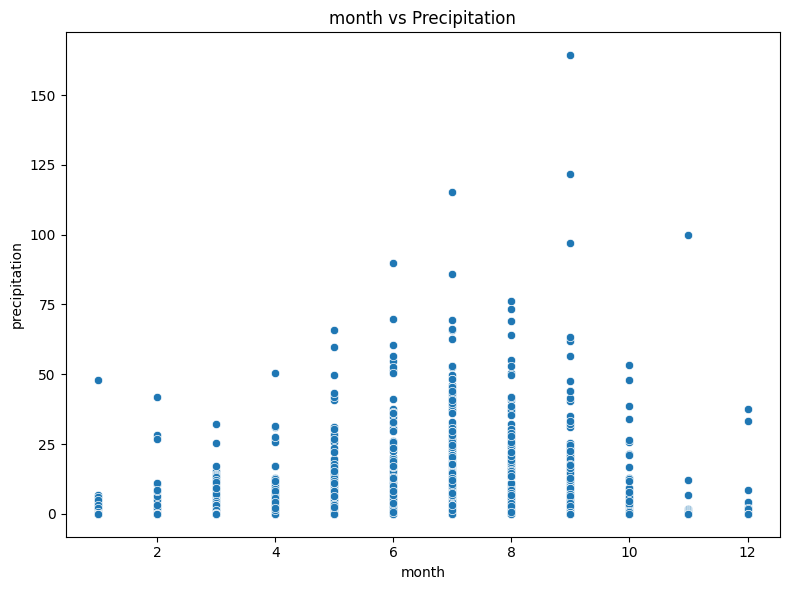

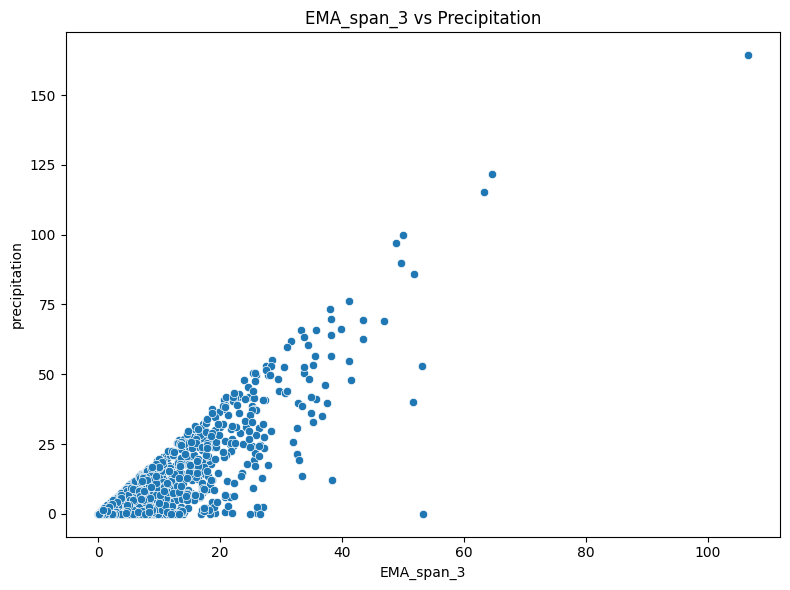

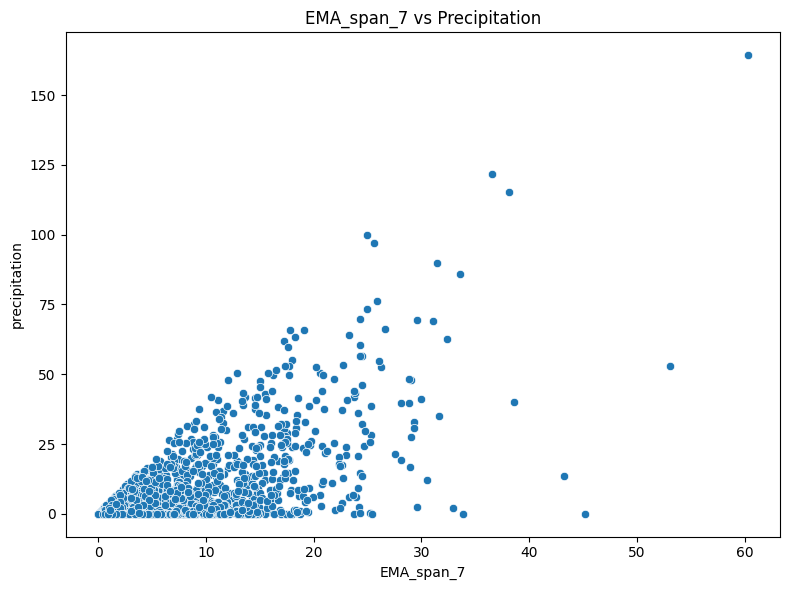

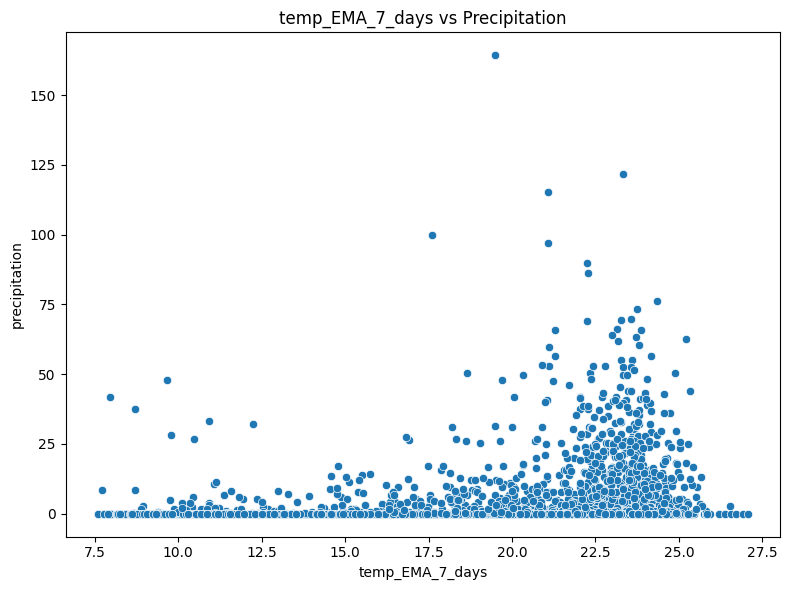

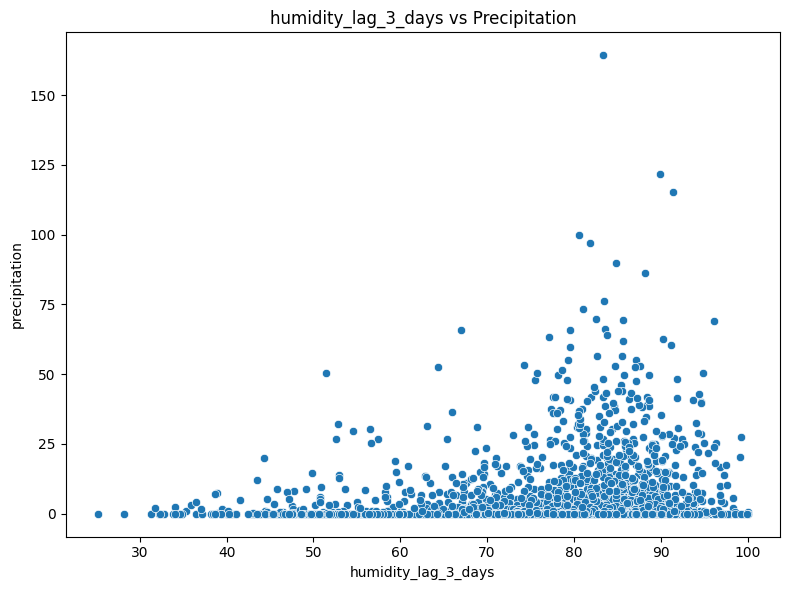

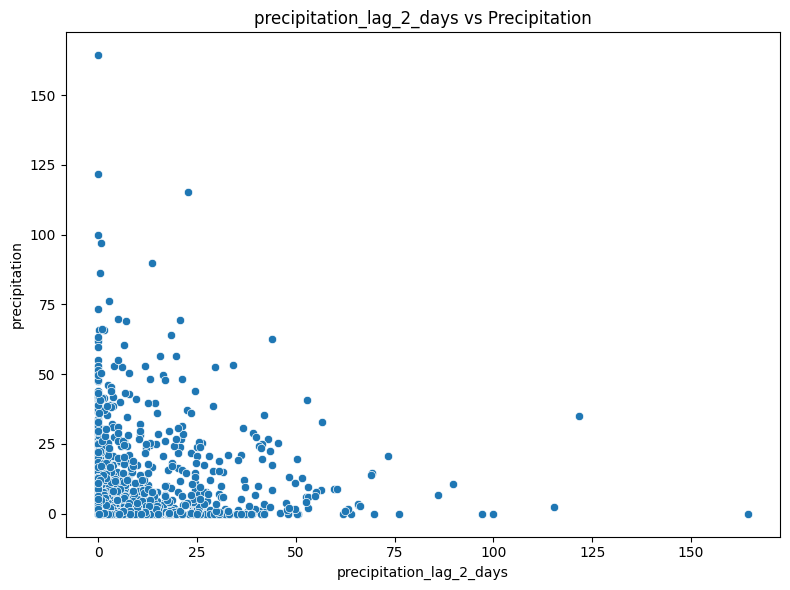

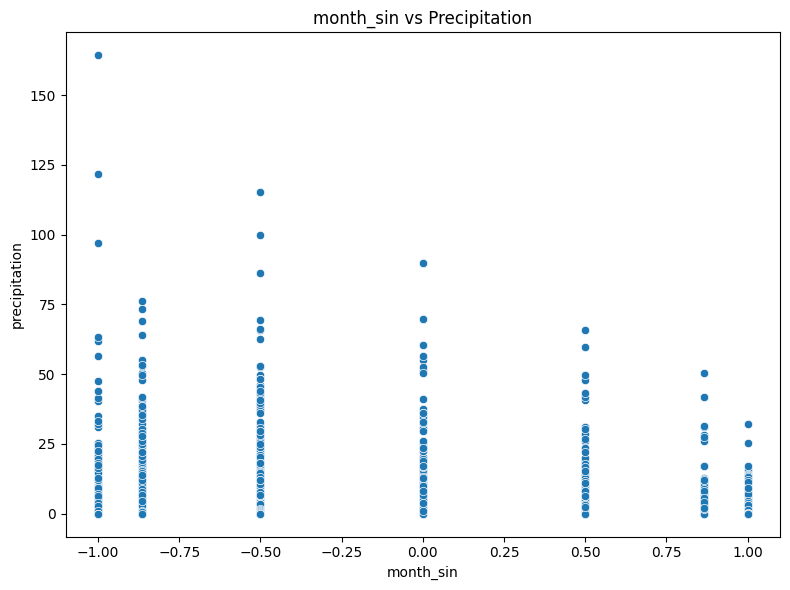

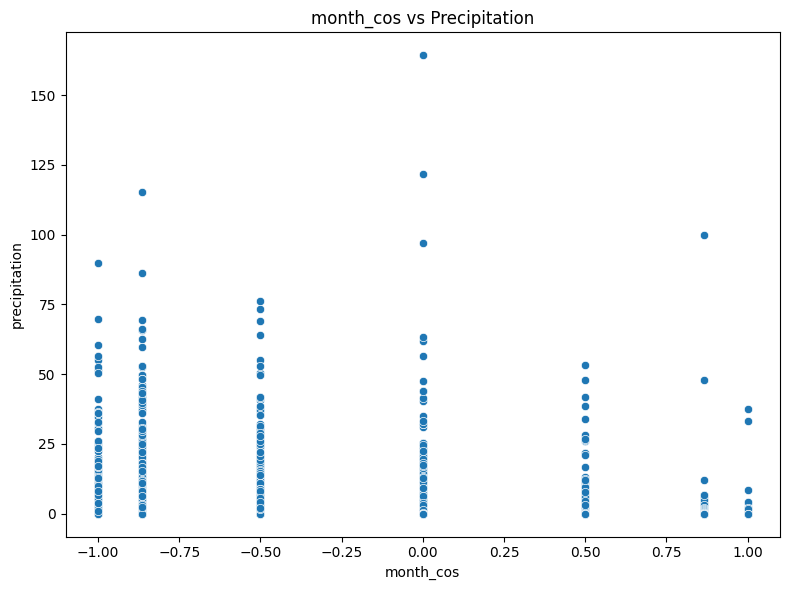

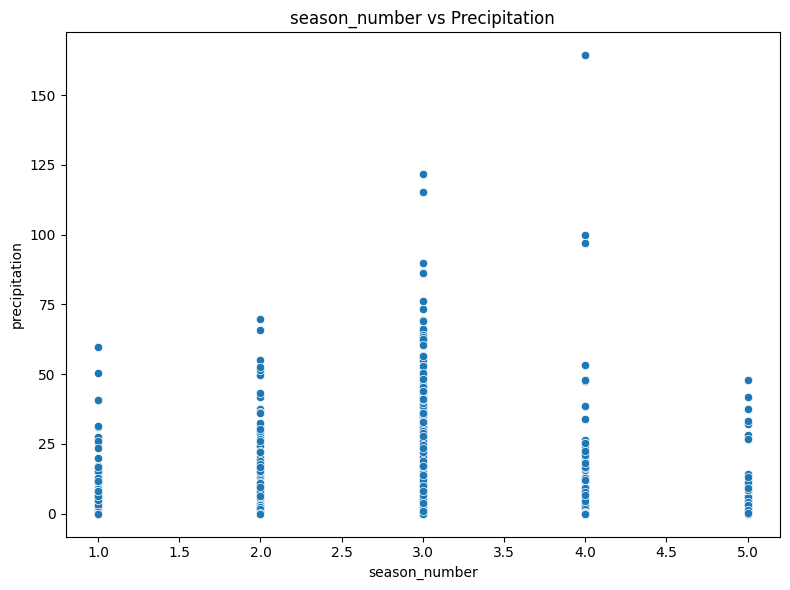

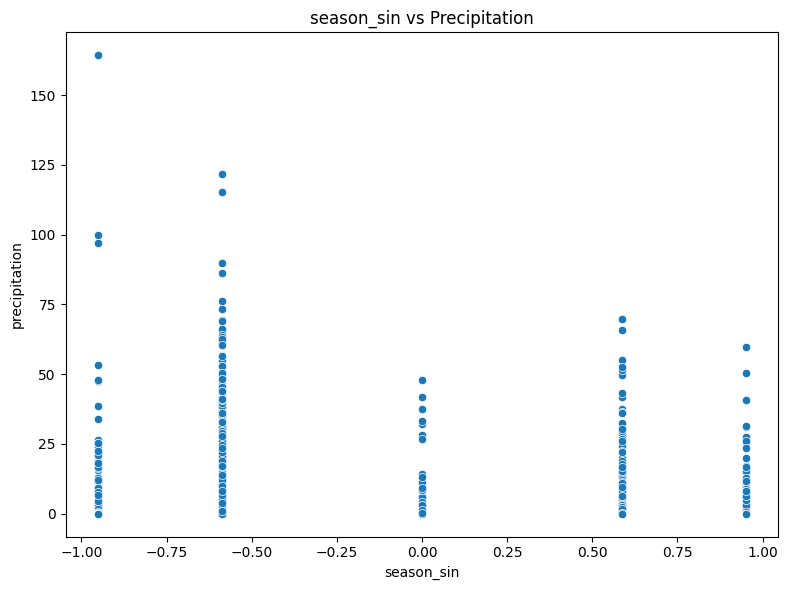

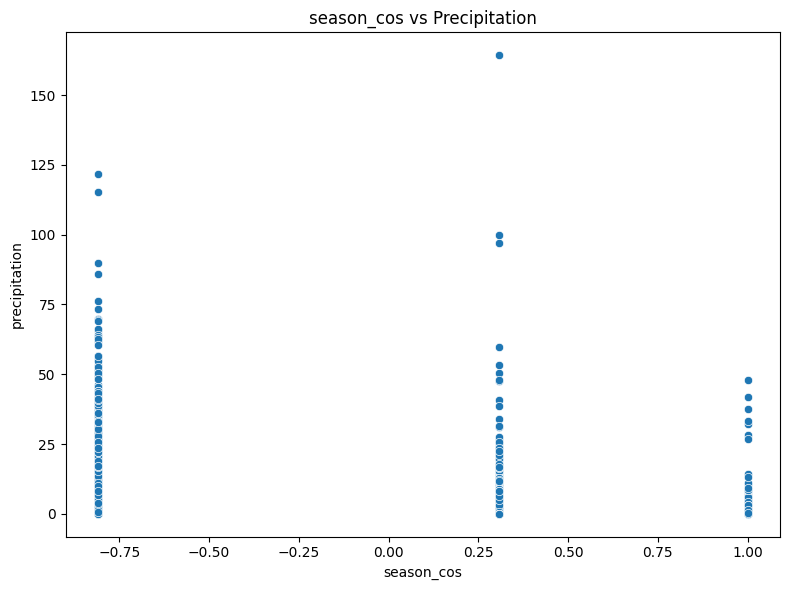

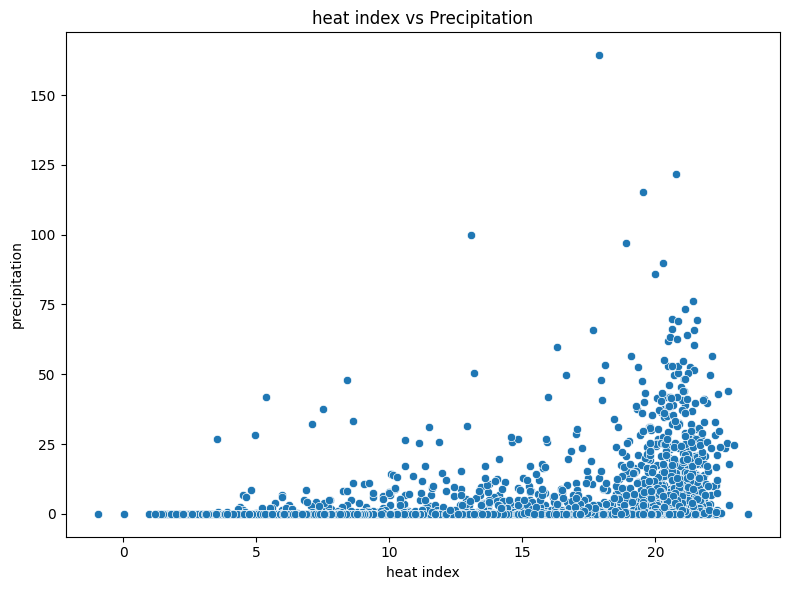

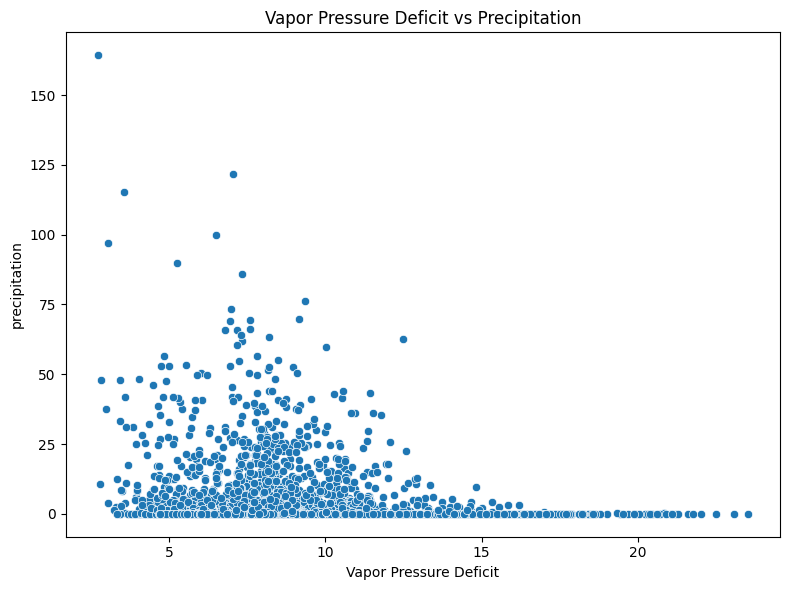

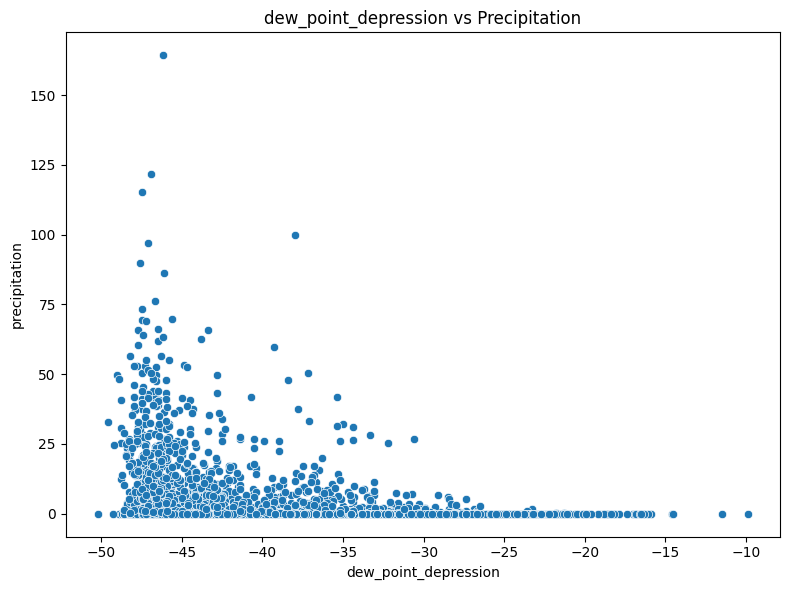

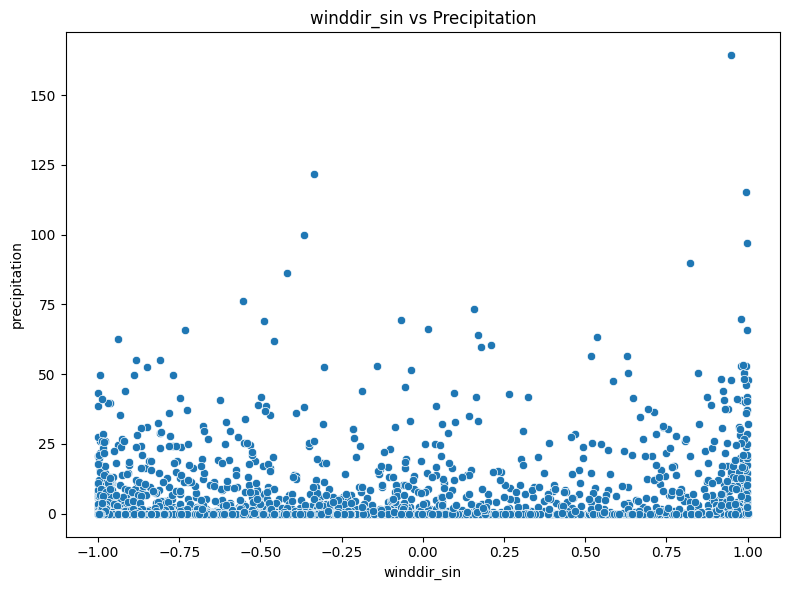

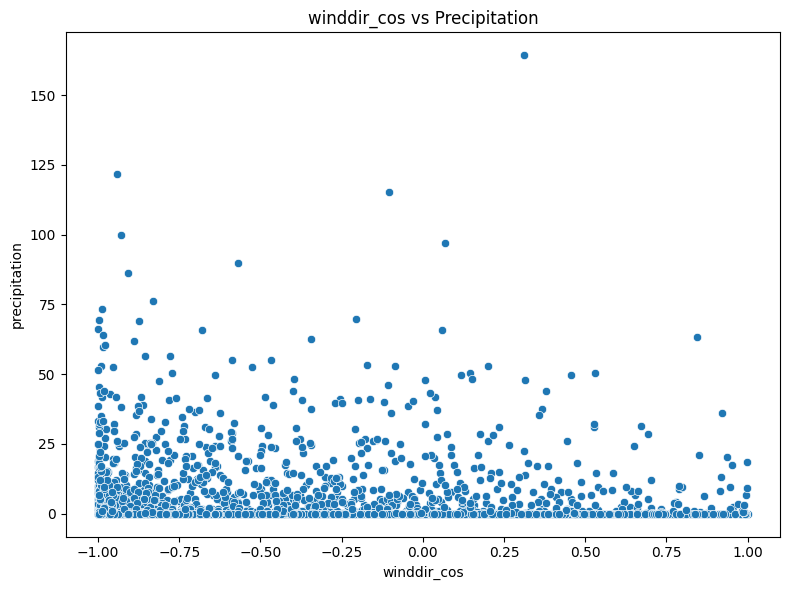

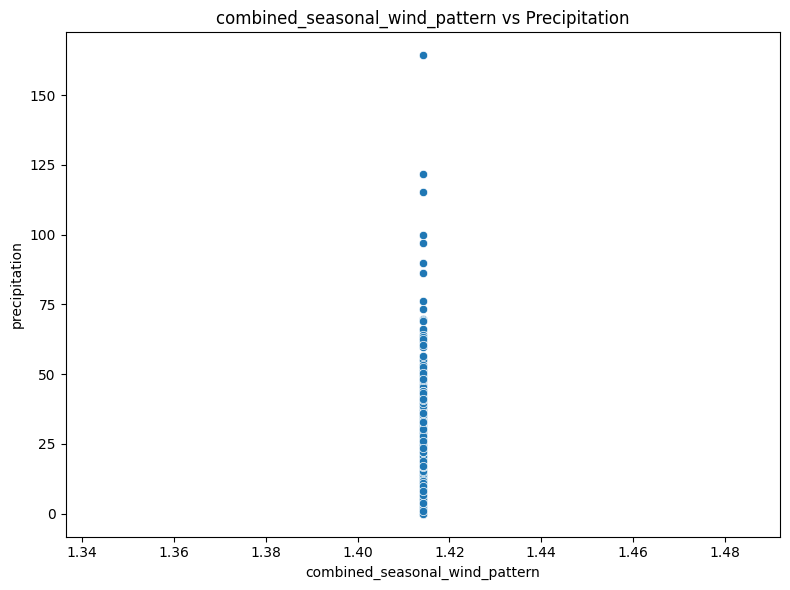

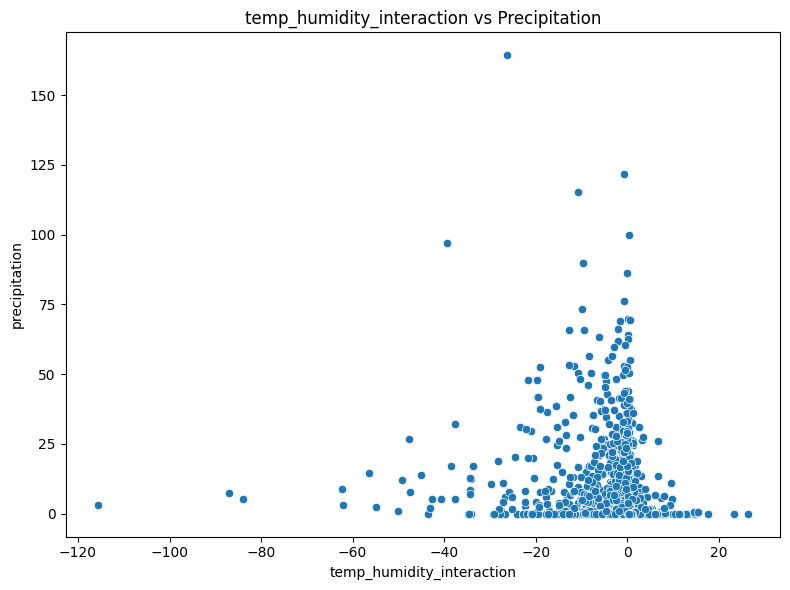

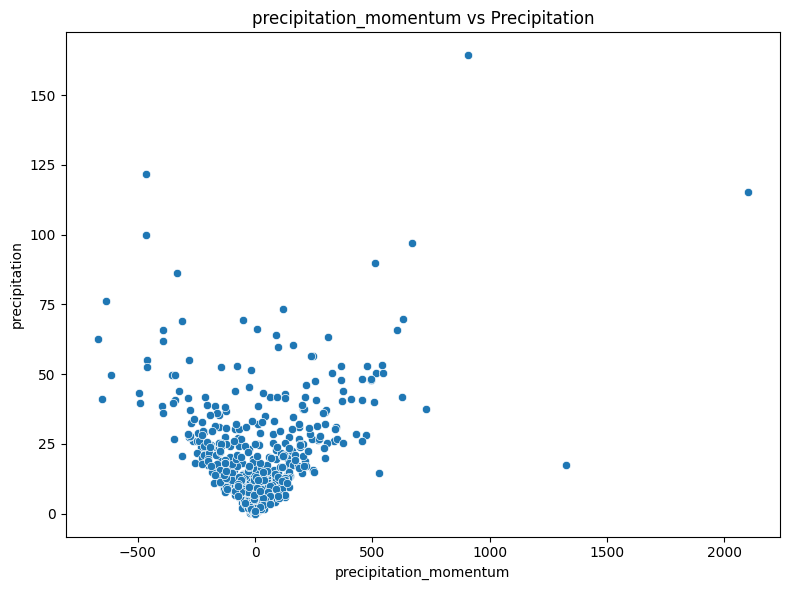

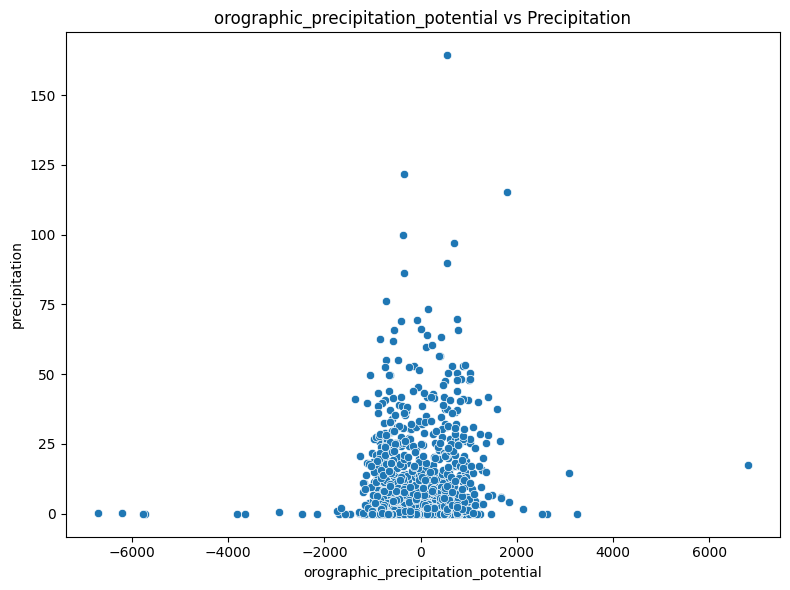

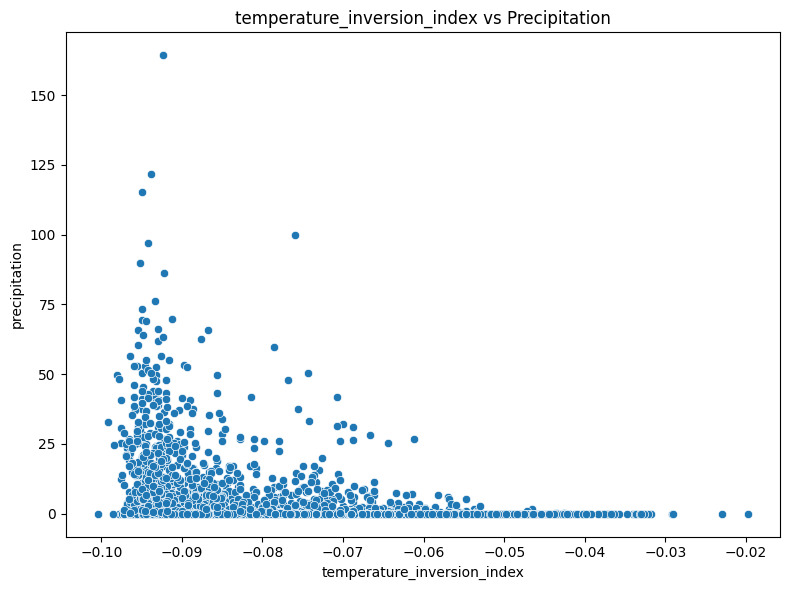

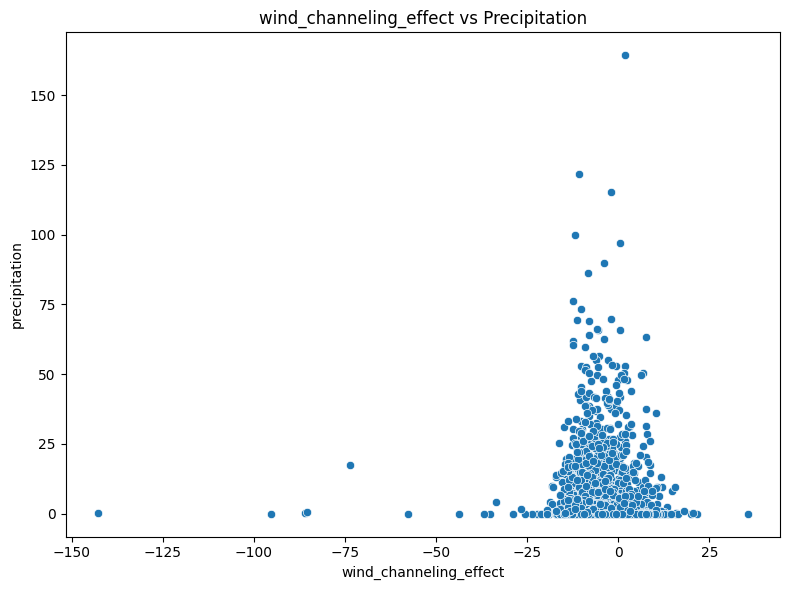

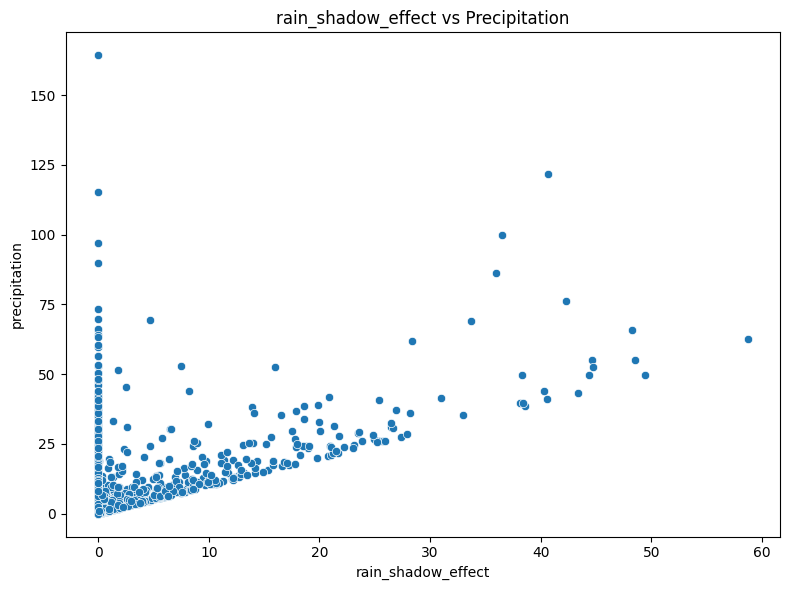

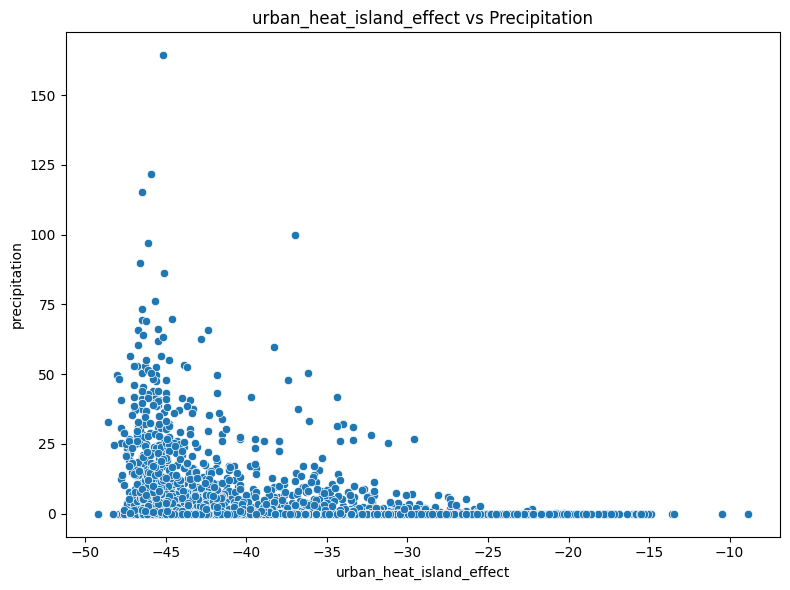

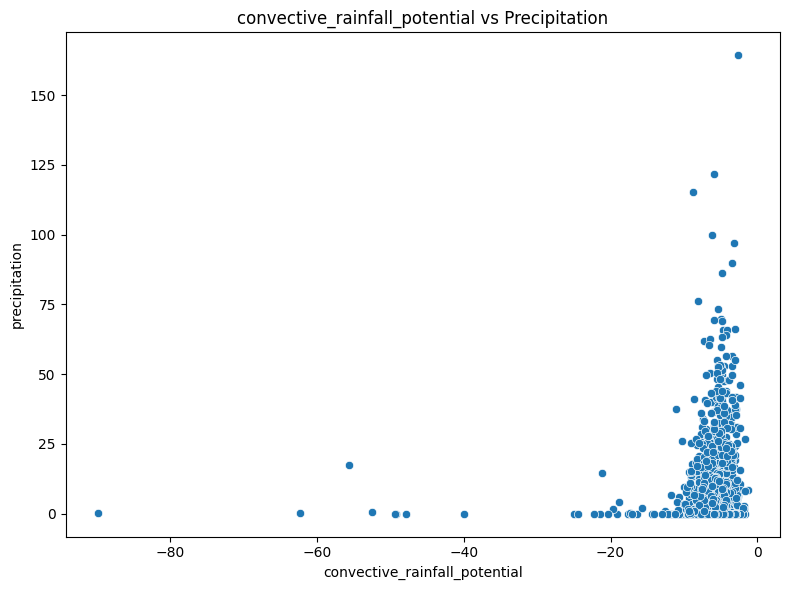

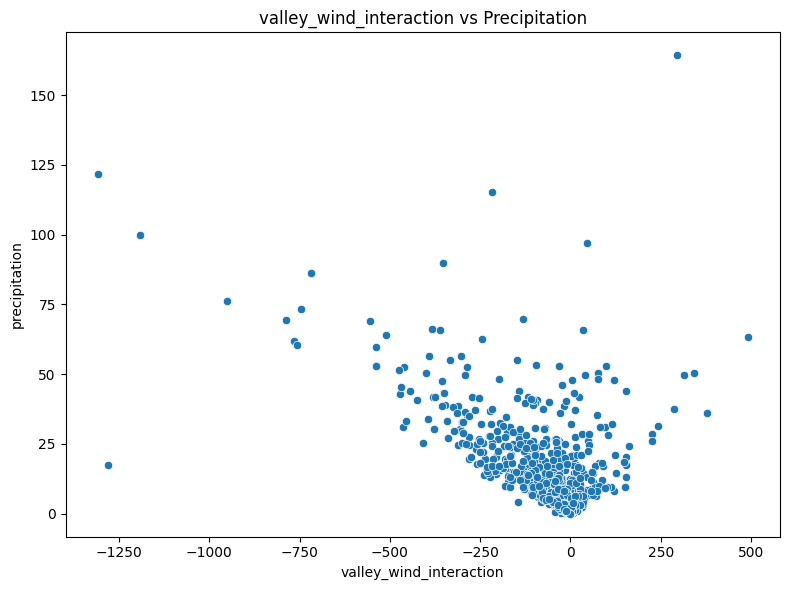

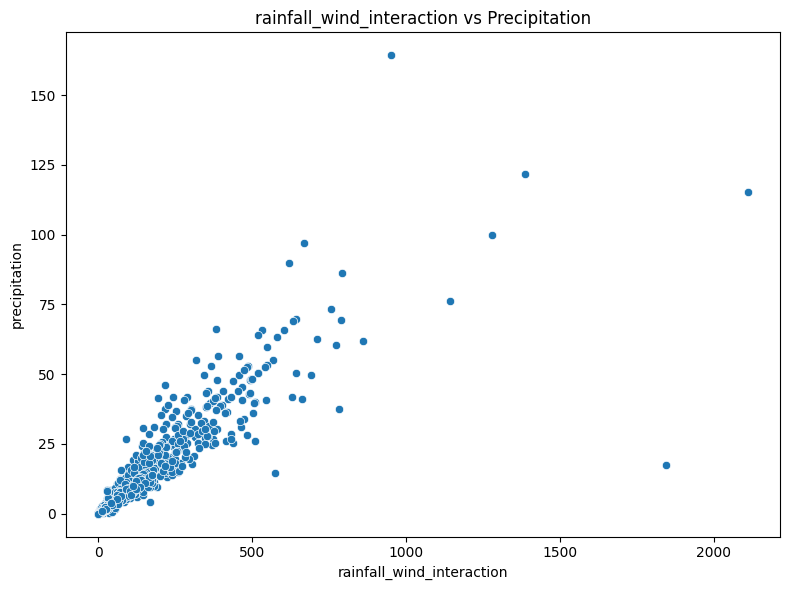

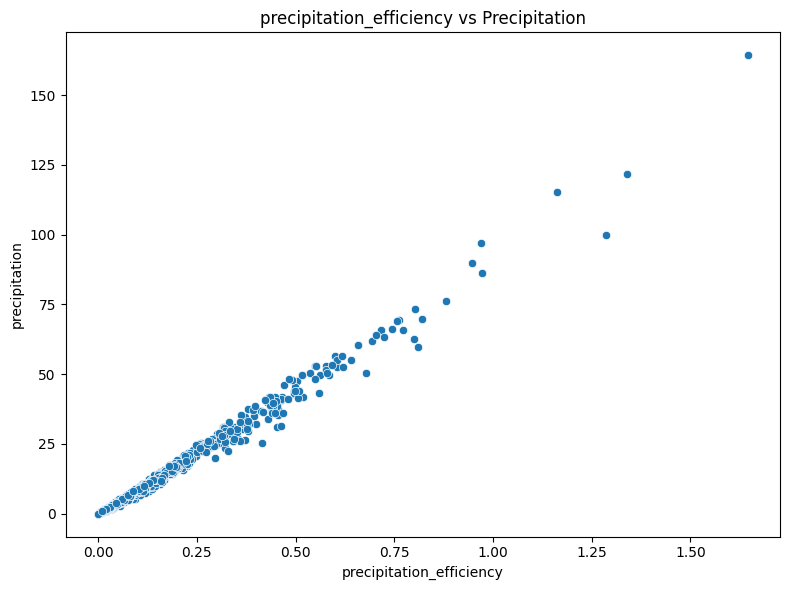

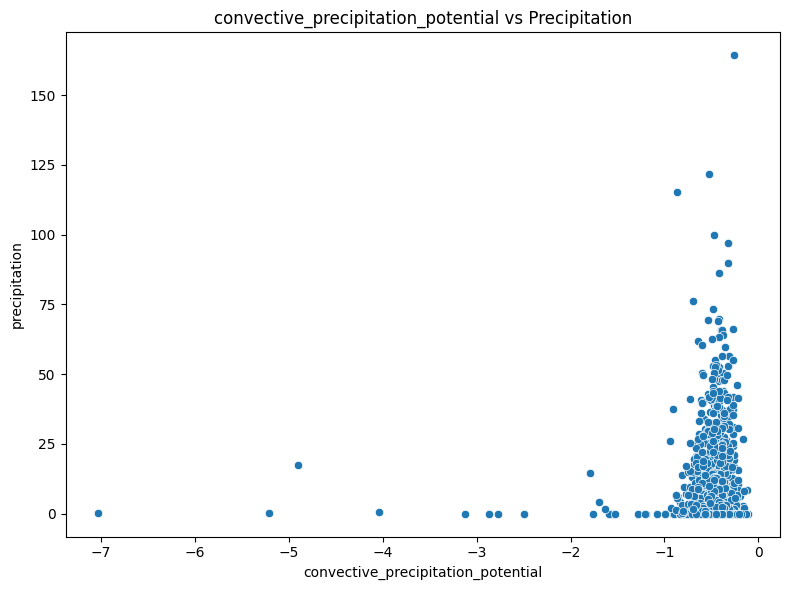

In [4]:
# Get numeric features (excluding target if it's included)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'precipitation' in numeric_features:
    numeric_features.remove('precipitation')

# Plot each numeric feature against target in separate figures
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df['precipitation'])
    plt.title(f'{feature} vs Precipitation')
    plt.xlabel(feature)
    plt.ylabel('precipitation')
    plt.tight_layout()
    plt.show()

In [18]:
numeric_df.dtypes

temp                                  float64
dew                                   float64
humidity                              float64
windspeed                             float64
winddir                               float64
sealevelpressure                      float64
precipitation                         float64
month                                   int64
EMA_span_3                            float64
EMA_span_7                            float64
temp_EMA_7_days                       float64
humidity_lag_3_days                   float64
precipitation_lag_2_days              float64
month_sin                             float64
month_cos                             float64
season_number                           int64
season_sin                            float64
season_cos                            float64
heat index                            float64
Vapor Pressure Deficit                float64
dew_point_depression                  float64
winddir_sin                       

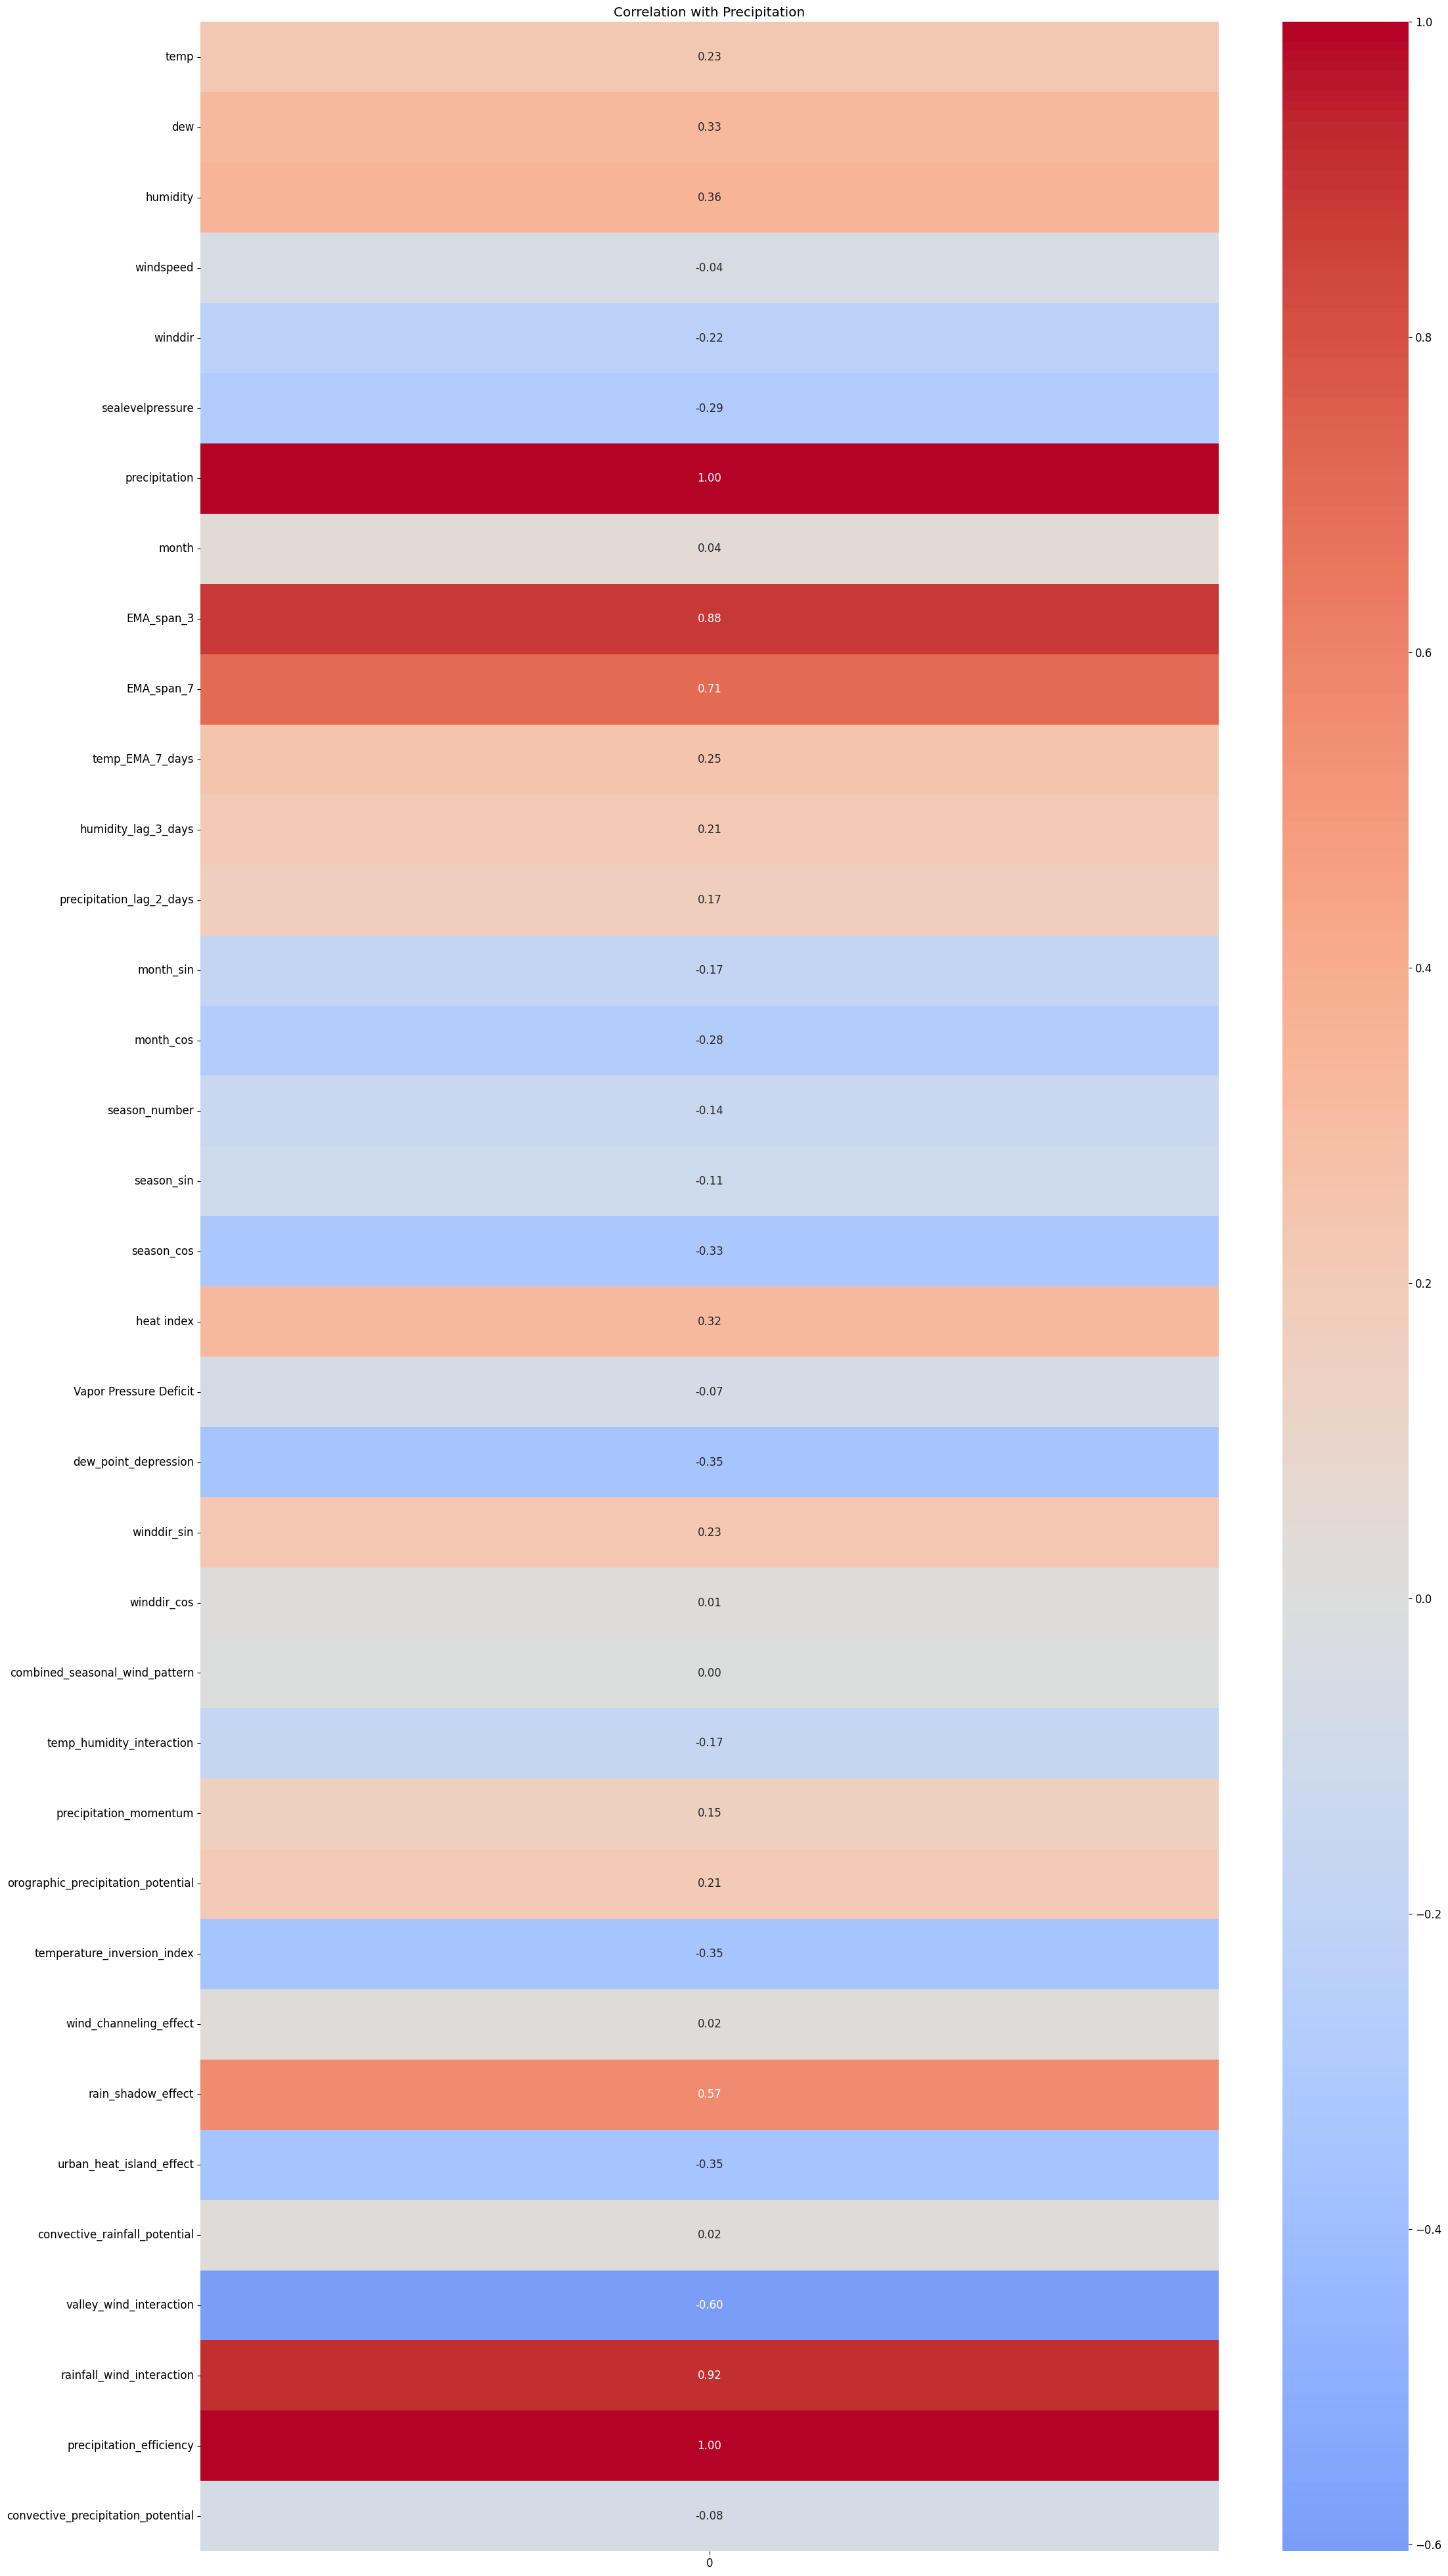

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features
numeric_df = df.select_dtypes(include=['int64', 'float64'])



# Plot heatmap
plt.rcParams.update({'font.size': 12})



# Compute correlation between 'precipitation' and other columns
precipitation_corr = numeric_df.corrwith(numeric_df["precipitation"])

# Convert to DataFrame for heatmap
precipitation_corr_df = precipitation_corr.to_frame()

# Plot
plt.figure(figsize=(25, 50))
sns.heatmap(precipitation_corr_df, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation with Precipitation")
plt.savefig("/home/momo/Downloads/dataset for prec/cleaned_data/03-interaction_features-visualizations/correlation heatmap/Pearson Correlation Matrix (Numeric Features).png")
# plt.show()

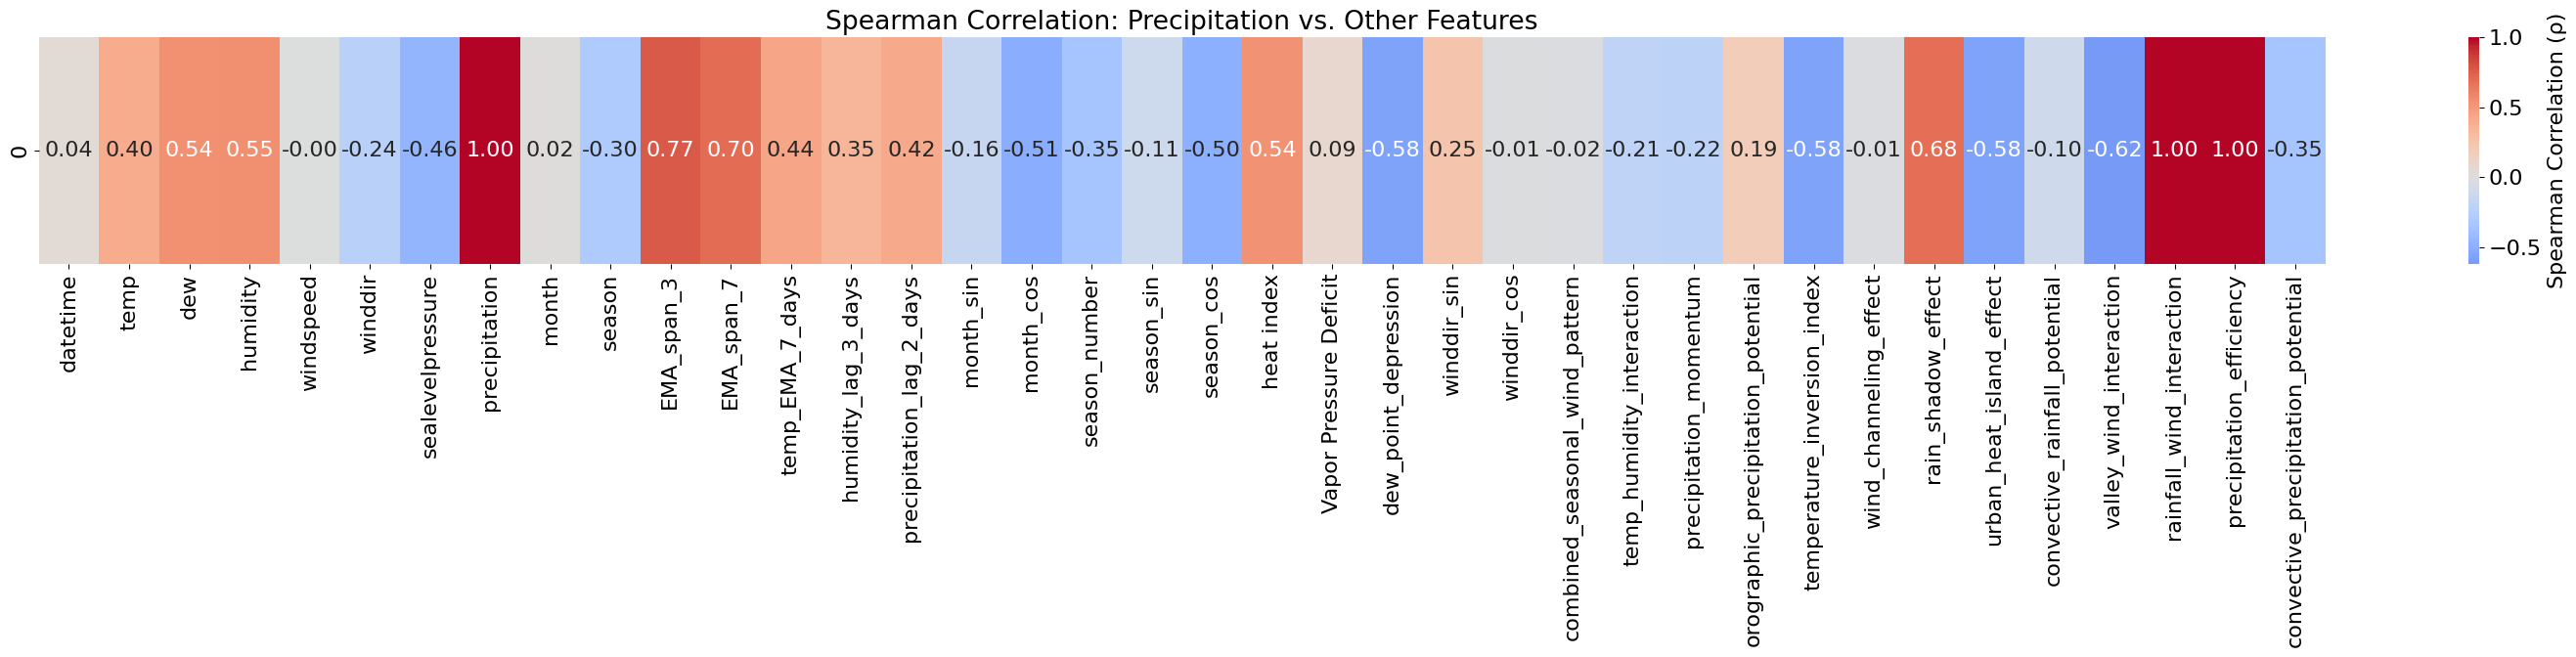

In [46]:
# Reshape correlations for heatmap
precipitation_corr_df = precipitation_corr.to_frame().T  # 1 row × N columns
plt.rcParams.update({'font.size': 16})

# Plot
plt.figure(figsize=(30, 7))  # Wide and short
sns.heatmap(
    precipitation_corr_df, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    center=0,
    cbar_kws={"label": "Spearman Correlation (ρ)"}
)
plt.title("Spearman Correlation: Precipitation vs. Other Features")
plt.tight_layout()
plt.savefig("cleaned_data/03-interaction_features-visualizations/correlation heatmap/correlation heatmapSpearman_Correlation_Heatmap.png")
plt.show()

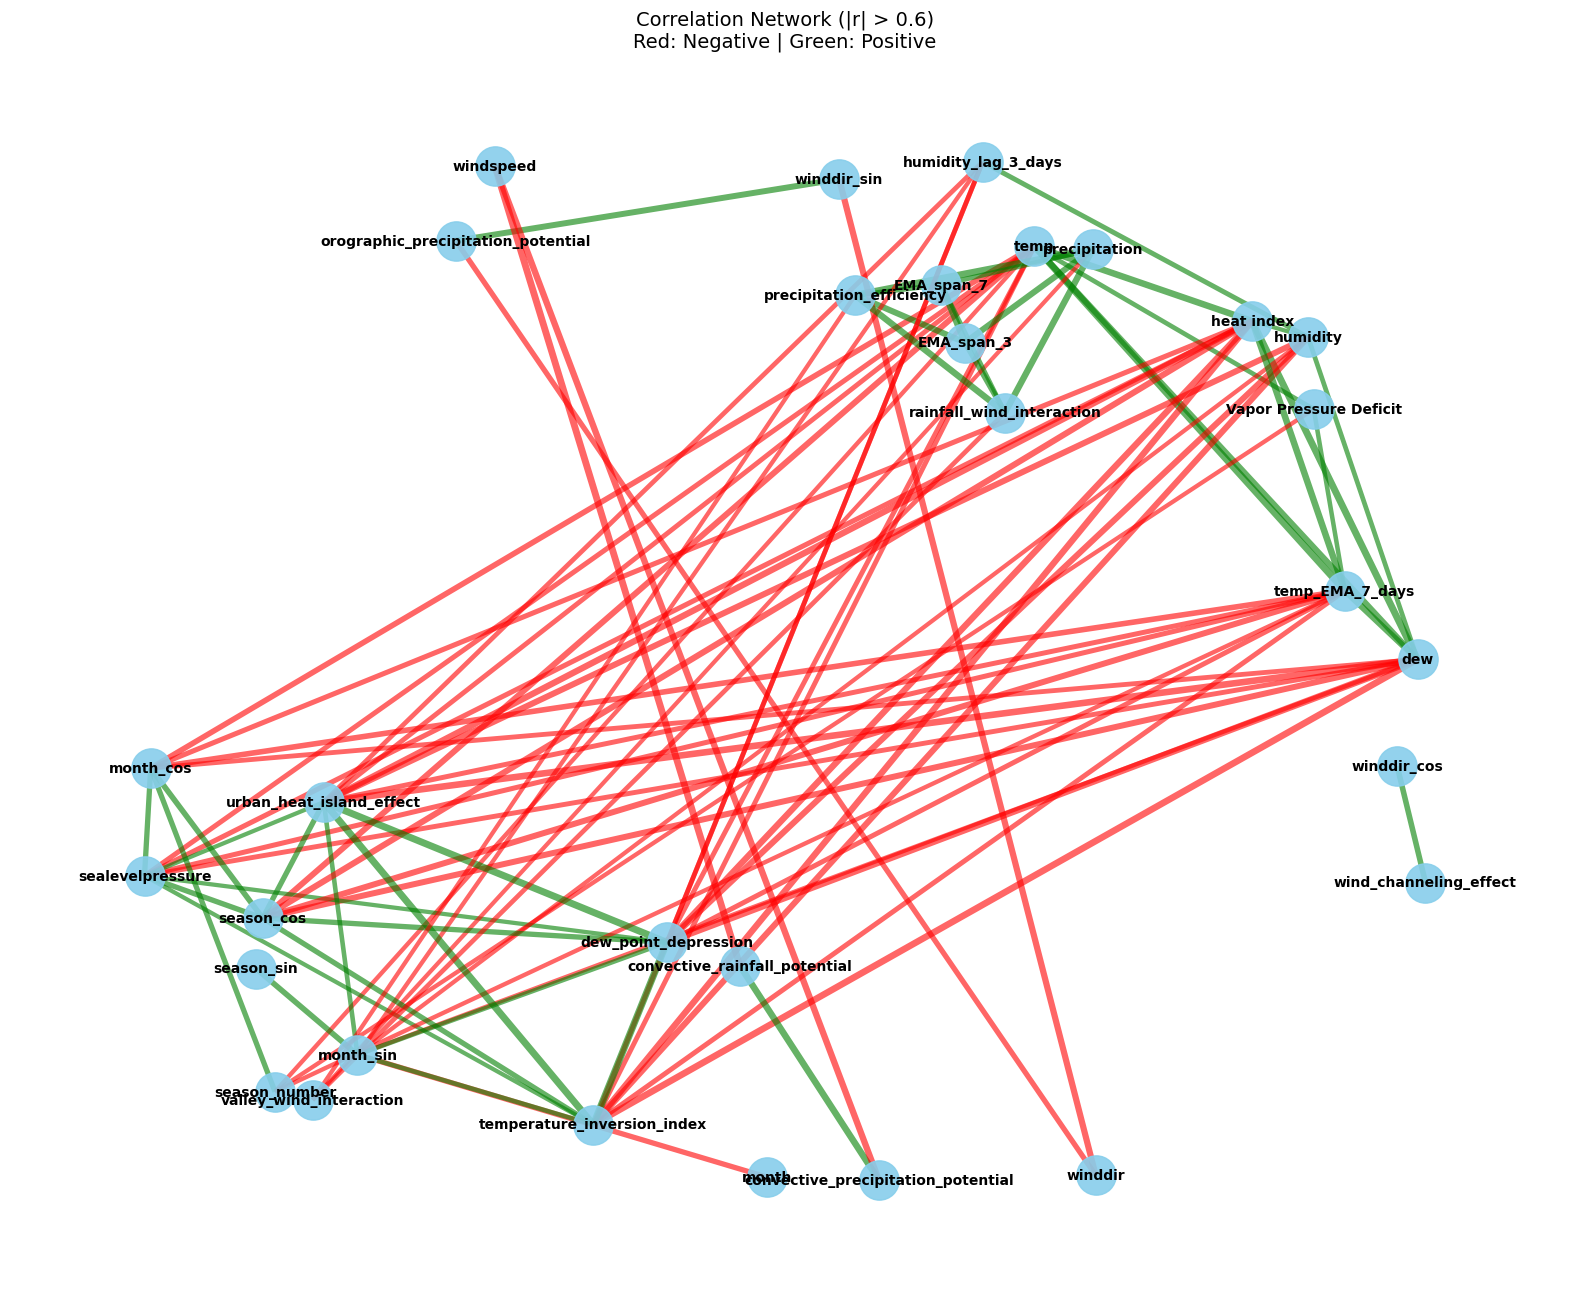

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Compute correlation matrix (Pearson/Spearman)
corr_matrix = df.select_dtypes(include=['number']).corr(method='pearson')

# Create graph
G = nx.Graph()
threshold = 0.6  # Adjust based on your needs (strictness)

# Add edges only if correlation exceeds threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            G.add_edge(
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                weight=corr_matrix.iloc[i, j],
                color='red' if corr_matrix.iloc[i, j] < 0 else 'green'
            )

# Draw the graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, k=0.5)  # k=node spacing parameter

# Extract edge colors/weights
edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]
weights = [abs(G[u][v]['weight']) * 5 for u, v in edges]  # Scale edge width

# Draw nodes/edges
nx.draw_networkx_nodes(
    G, pos, 
    node_size=800,
    node_color='skyblue',
    alpha=0.9
)
nx.draw_networkx_edges(
    G, pos, 
    edge_color=colors,
    width=weights,
    alpha=0.6
)
nx.draw_networkx_labels(
    G, pos, 
    font_size=10,
    font_weight='bold'
)

# Customize plot
plt.title(
    f"Correlation Network (|r| > {threshold})\n"
    "Red: Negative | Green: Positive",
    fontsize=14
)
plt.axis('off')

# Highlight target variable (if applicable)
target_node = 'price'  # Replace with your target column
if target_node in G.nodes():
    nx.draw_networkx_nodes(
        G, pos, 
        nodelist=[target_node],
        node_size=1200,
        node_color='gold',
        edgecolors='black',
        linewidths=2
    )

plt.show()

In [34]:
# Correlation Network Graph
# Element	Meaning
# Node (Circle)	A feature in your dataset (e.g., age, income, price).
# Edge (Line)	A correlation between two features.
# Edge Color	Red = Negative correlation, Green = Positive correlation.
# Edge Thickness	Thicker = Stronger correlation (absolute value).
# Node Size	Larger = More connections (highly correlated with other features).
# Node Position	Closer nodes = Stronger relationships (via force-directed layout).

In [35]:
df.dtypes

datetime                               object
temp                                  float64
dew                                   float64
humidity                              float64
windspeed                             float64
winddir                               float64
sealevelpressure                      float64
precipitation                         float64
month                                   int64
season                                 object
EMA_span_3                            float64
EMA_span_7                            float64
temp_EMA_7_days                       float64
humidity_lag_3_days                   float64
precipitation_lag_2_days              float64
month_sin                             float64
month_cos                             float64
season_number                           int64
season_sin                            float64
season_cos                            float64
heat index                            float64
Vapor Pressure Deficit            